<a href="https://colab.research.google.com/github/carolflyjs/cs230/blob/master/Base_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import Packages

In [1]:
import pandas as pd
import os
import tensorflow as tf
import tensorflow_hub as hub
import keras
import numpy as np
from keras.layers import Input, Dense, concatenate, Dot, Embedding
from keras.engine import Layer
from keras.models import Model
from keras import backend as K
from keras.preprocessing import text
from keras.preprocessing import sequence
import matplotlib.pyplot as plt
from sklearn.utils import shuffle

Using TensorFlow backend.


### Load File and Prep Data

In [0]:
def load_file(path, delimiter=","):
    df = pd.read_csv(path, delimiter=delimiter)
    df = shuffle(df)
    class_dict = {
      "BT": 0,
      "NT": 1,
      "NPT": 2,
      "PT": 2,
      "RT": 3,
      "URT": 3
    }
    df["label"] = df["label"].apply(lambda x: class_dict[x])
    return df

def data_prep(df, x_columns, y_columns):
    X_train = df[x_columns]
    Y_train = df[y_columns]
    return X_train, Y_train

In [0]:
df = load_file("/content/drive/My Drive/cs230/train.csv")
X_train_raw, Y_train = data_prep(df, ["source", "target"], ["label"])
Y_train_labels = keras.utils.to_categorical(Y_train, num_classes=4)

In [4]:
display(df.groupby(df["label"]).count())

,source,target
label,,
0,10010,10010
1,10008,10008
2,19982,19982
3,20207,20207


### Tokenize text columns and pad to same length

In [0]:
def tokenize(X_train):
    t = text.Tokenizer()
    fit_text = pd.concat([X_train["source"], X_train["target"]])
    t.fit_on_texts(fit_text)
    X_train_transformed = X_train.copy()
    X_train_transformed["source"] = t.texts_to_sequences(X_train["source"])
    X_train_transformed["target"] = t.texts_to_sequences(X_train["target"])
    max_length = 0
    for series in ["source", "target"]:
        current_max = (df[series].apply(lambda ls: len(ls))).max()
        if current_max > max_length:
            max_length = current_max
    max_length = max_length
    vocab_size = len(t.index_word) + 1
    return X_train_transformed,  max_length, vocab_size

In [0]:
X_train_tokenized, max_value, vocab_size = tokenize(X_train_raw)

In [0]:
def pad(X, max_value):
    source = sequence.pad_sequences(X["source"],  maxlen=max_value)
    target = sequence.pad_sequences(X["target"],  maxlen=max_value)
    return pd.DataFrame(data=np.concatenate((source, target), axis=1))

In [0]:
X_train_padded = pad(X_train_tokenized, max_value=max_value)

### Build a base model with one hidden layer

1.   L1 is an embedding layer to embed all words. It is then flattened.
2.   L2 is the softmax output.

Use standard cross entropy loss function.




In [0]:
def build_naive_embedding_model(): 
    X_input = Input(shape=(max_value * 2,), dtype="int32")
    X = Embedding(vocab_size, 10)(X_input)
    X = keras.layers.Flatten("channels_last")(X)
    X = Dense(4, activation="softmax")(X)

    model = Model(inputs=[X_input], outputs=X)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()

    return model

In [10]:
model = build_naive_embedding_model()
history = model.fit([X_train_padded], Y_train_labels, validation_split=0.1, epochs=20, batch_size=16, shuffle=True) 






Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 146)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 146, 10)           112120    
_________________________________________________________________
flatten_1 (Flatten)          (None, 1460)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 5844      
Total params: 117,964
Trainable params: 117,964
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 54186 samples, validate on 6021 samples
Epoch 1/20





54186/54186 [==============================] - 10s 183us/step - loss: 0.7926 - acc: 

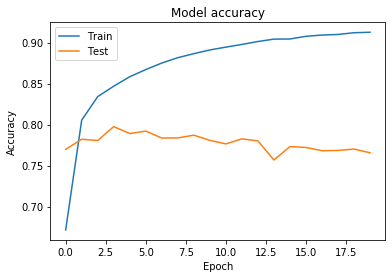

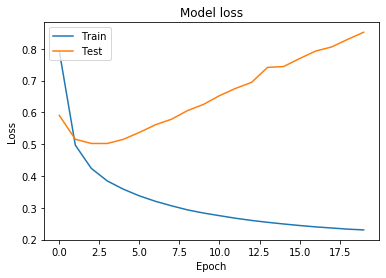

In [11]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()